In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

In [2]:
z_ret = np.load("output/retarded_energies.npy")
energies = z_ret.real
eigvals_bare = np.load("output/eigvals_Hbare.npy")
eigvals_eff = np.load("output/eigvals_Heff.npy")
dos = np.load("output/dft_dos.npy")
Eref, Tref_dft = np.load("reference/ET_dft.npy")

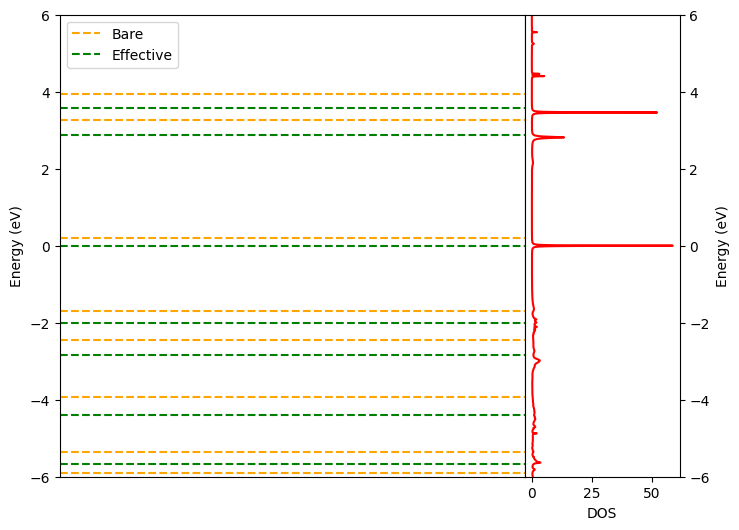

In [20]:
fig, (ax_eigen, ax_dos) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1]})

for eig_bare in eigvals_bare:
    ax_eigen.axhline(eig_bare, linestyle='--', color='orange', label='Bare' if eig_bare == eigvals_bare[0] else None)
for eig_eff in eigvals_eff:
    ax_eigen.axhline(eig_eff, linestyle='--', color='green', label='Effective' if eig_eff == eigvals_eff[0] else None)

ax_eigen.set_ylabel("Energy (eV)")
ax_eigen.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_eigen.legend(loc='upper left', fontsize=10)

ax_dos.plot(dos, energies, color='red', label='DOS')
ax_dos.set_xlabel("DOS")
ax_dos.yaxis.set_label_position("right")
ax_dos.yaxis.tick_right()

y_min = -6
y_max = 6

ax_eigen.set_ylim(y_min, y_max)
ax_dos.set_ylim(y_min, y_max)

ax_dos.set_yticks(ax_eigen.get_yticks())
ax_dos.set_ylabel("Energy (eV)")


plt.subplots_adjust(wspace=0)
plt.show()


In [30]:
# Find all peaks
peaks, properties = find_peaks(dos, height=0)

# Get the heights of the peaks
peak_heights = properties["peak_heights"]

# Find the indices of the n largest peaks
n = 9  # Number of largest peaks to find
largest_peaks_indices = np.argsort(peak_heights)[-n:]

# Get the corresponding energy positions and heights
largest_peaks_positions = energies[peaks[largest_peaks_indices]]
largest_peaks_heights = dos[peaks[largest_peaks_indices]]

# Sort the largest peaks by increasing energy position
sorted_indices = np.argsort(largest_peaks_positions)
sorted_positions = largest_peaks_positions[sorted_indices]
sorted_heights = largest_peaks_heights[sorted_indices]

# Print the positions and heights of the largest peaks in increasing energy order
print("Energy eigenstates (in eV):", eigvals_eff)
print("Positions of the largest peaks (in eV):", sorted_positions)
print("Heights of the largest peaks:", sorted_heights)



Energy eigenstates (in eV): [-6.63593217e+00 -5.68099396e+00 -4.40898902e+00 -2.84754829e+00
 -2.00819522e+00  9.27448665e-04  2.86647633e+00  3.58736183e+00
  7.00083221e+00]
Positions of the largest peaks (in eV): [-7.835e+00 -7.325e+00 -6.434e+00 -6.297e+00  1.000e-03  2.814e+00
  3.461e+00  4.405e+00  6.953e+00]
Heights of the largest peaks: [ 5.9463534   6.7804448  16.47013968 10.1959361  58.5808665  13.42321073
 52.0776558   5.15378787 11.9743728 ]


In [31]:
occupancies = np.load("output/occupancies_mu0.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.398743131477257

In [3]:
occupancies = np.load("output/occupancies_mu1e-3.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.787299188461592

In [4]:
occupancies

array([1.86731257, 1.02409175, 1.01085735, 0.96353067, 0.95473459,
       1.07815776, 1.00357507, 1.02367331, 1.86136613])